<a href="https://colab.research.google.com/github/dlohmus/rattaringlus/blob/main/Tartu_rattaringlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tartu rattaringluse rataste kasutatavuse analüüs

##Rühmatöö aines andmeteaduse võimalused äriettevõttes

###Raivo Kasepuu
###Diana Lõhmus
###Irina Rips
###Lauri Ütsik

## Sissejuhatus

Tartu Rattaringlus on avalik iseteenindusega rataste kasutamise süsteem lühikesteks sõitudeks Tartu linnas. Meie analüüsi põhiliseks eesmärgiks on saada ülevaade rataste kasutusest, et optimeerida laenutuspunktide asukohti.
Kõrvaleesmärkidena aitab meie analüüs planeerida jalgrataste korralisi hooldusi. 

Andmete analüüsimiseks kasutatakse Google Collaborate keskkonda ja Pythoni programmeerimise keelt. Andmete analüüsimisel kasutatakse kirjeldavat statistikat ja tunnuste visualiseerimiseks Plotnine ning Matpotlib abil loodud graafikuid.

## Andmeallikad

Analüüsis kasutatakse Tartu Rattaringluse avaandmeid aadressilt https://avaandmed.eesti.ee/datasets/tartu-linnavalitsuse-andmekogud-rattaringlus. Andmed on täielikud. Kokku on andmeid ligikaudu 170 000 rida. 

## Andmete kirjeldus koos andmetüübiga

1.   Laenutamise kuupäev  /kuupäev/
2.   Laenutamise kellaaeg /kellaaeg/
3.   Tagastamise kuupäev  /kuupäev/
4.   Tagastamise kellaaeg  /kellaaeg/
5.   Liikmelisus (mille alusel laenutati) /tekst/
6.   Sõidu kilometraaz (km) /ujukomaarv/
7.   Laenutuse kestvus (min) /ujukomaarv/
8.   Ratta ID /täisarv/
9.   Jalgratta tüüp (tavaratas või elektriratas) /tekst/
10.  Laenutuse hind /ujukomaarv/
11.  Laenutuspunkt  /tekst/
12.  Tagastuspunkt  /tekst/



In [1]:
import pandas as pd
import numpy as np

In [2]:
url= 'https://github.com/dlohmus/rattaringlus/raw/main/Smart_Bike_Tartu_july_2019.xlsx'

In [3]:
rattaringlus_df = pd.read_excel(url, sheet_name ='Tartu Smart Bike July 2019')

In [4]:
print(rattaringlus_df.columns.ravel())
display(rattaringlus_df.head(3))
rattaringlus_df.info()

['Unlock Date' 'Unlock Time' 'Lock Date' 'Lock Time' 'Membership' 'Length'
 'Duration (Minutes)' 'Bike No' 'Bike Type' 'Cost' 'Start Station'
 'End Station']


,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station
0,2019-07-01 00:00:00,08:05:03,2019-07-01 00:00:00,08:05:03,Technician,0,0.0,2207.0,Pedelec,0.0,Raudteejaam,Raudteejaam
1,2019-07-01 00:00:00,08:12:05,2019-07-01 00:00:00,08:12:05,Technician,0,0.0,2298.0,Pedelec,0.0,Raudteejaam,Raudteejaam
2,2019-07-01 00:00:00,09:33:21,2019-07-01 00:00:00,09:33:21,Technician,0,0.0,2654.0,Pedelec,0.0,Töökoda,Töökoda


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170023 entries, 0 to 170022
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unlock Date         170010 non-null  object 
 1   Unlock Time         170010 non-null  object 
 2   Lock Date           170010 non-null  object 
 3   Lock Time           170010 non-null  object 
 4   Membership          170003 non-null  object 
 5   Length              170003 non-null  object 
 6   Duration (Minutes)  169996 non-null  float64
 7   Bike No             169996 non-null  float64
 8   Bike Type           169996 non-null  object 
 9   Cost                169996 non-null  float64
 10  Start Station       169996 non-null  object 
 11  End Station         169996 non-null  object 
dtypes: float64(3), object(9)
memory usage: 15.6+ MB


###Andmete ettevalmistamine

Enne analüüsi tegemist puhastame andmed. Selleks eemaldame kõigepealt andmetest tühjad read ning ning need read, kus laenutuse kuupäev ei jäänud vaadeldava juuli 2019 perioodi (7 rida) ning read, kus rattanumber puudub (7 rida). Lisaks eemaldame andmete hulgast tehnikute jalgrataste kasutuse (10 060 rida), sest nad transportisid jalgrattaid veokil laenutuspunktist töökotta või vastupidi. Veel on andmete hulgas ridu, kus laenutuspunkti nimi on "Töökoda" (228 rida) või "Warehouse" (20 rida), need read võib samuti eemaldada. Sellenimelisi laenutuspunkte tegelikult ei eksisteeri ning tegemist on testkasutusega.

Samuti on andmetes veerge, mida me oma analüüsis ei kasuta. Veerus laenutuse hind on kõik väärtused nullid, sest tegemist oli prooviperioodiga. Andmetes on juba olemas veerg sõidu kestvus (minutites), seetõttu ei ole meil vaja oma analüüsis kasutada veerge laenutamise kellaaeg ning tagastamise kellaaeg.

In [5]:
#Tühjade ridade eemaldamine
puudu = pd.isnull(rattaringlus_df['Unlock Date']) 
olemas = pd.notnull(rattaringlus_df['Unlock Date'])

rattaringlus_df = rattaringlus_df.loc[olemas]

In [9]:
#Otsime read, kus puudub rattanumber ja eemaldame need
display(rattaringlus_df['Bike No'].isnull().values.any())
rattaringlus_df.dropna(subset = ['Bike No'], inplace=True)

True

In [10]:
#Vigaste andmete eemaldamine ja andmetüüpide teisendamine
#Vaatame laenutamise kuupäeva veeru väärtuseid
erindid = rattaringlus_df['Unlock Date'].unique()
print(erindid)

#Otsime andmetes hulgast read, kus laenutamise kuupäev ei ole kuupäeva kujul või ei jää vahemikku 01.07.2019 - 31.07.2019 ja eemaldame need
display(rattaringlus_df.loc[rattaringlus_df['Unlock Date']== 'Mobile App'])
rattaringlus_df.drop(rattaringlus_df[rattaringlus_df['Unlock Date']== 'Mobile App'].index, inplace = True)

#Teisendame laenutamise kuupäeva õigesse formaati
rattaringlus_df['Unlock Date'] = rattaringlus_df['Unlock Date'].astype('datetime64[ns]')

display(rattaringlus_df.loc[rattaringlus_df['Unlock Date'] < '2019-07-01'])
rattaringlus_df.drop(rattaringlus_df[rattaringlus_df['Unlock Date'] < '2019-07-01'].index, inplace = True)



[datetime.datetime(2019, 7, 1, 0, 0) datetime.datetime(2019, 7, 2, 0, 0)
 datetime.datetime(2019, 7, 3, 0, 0) datetime.datetime(2019, 7, 4, 0, 0)
 datetime.datetime(2019, 7, 5, 0, 0) datetime.datetime(2019, 7, 6, 0, 0)
 datetime.datetime(2019, 7, 7, 0, 0) datetime.datetime(2019, 7, 8, 0, 0)
 datetime.datetime(2019, 7, 9, 0, 0) datetime.datetime(2019, 7, 10, 0, 0)
 datetime.datetime(2019, 7, 11, 0, 0) datetime.datetime(2019, 7, 12, 0, 0)
 datetime.datetime(2019, 7, 13, 0, 0) datetime.datetime(2019, 7, 14, 0, 0)
 datetime.datetime(2019, 7, 15, 0, 0) datetime.datetime(2019, 7, 16, 0, 0)
 datetime.datetime(2019, 7, 17, 0, 0) datetime.datetime(2019, 7, 18, 0, 0)
 datetime.datetime(2019, 7, 19, 0, 0) datetime.datetime(2019, 7, 20, 0, 0)
 datetime.datetime(2019, 7, 21, 0, 0) datetime.datetime(2019, 7, 22, 0, 0)
 datetime.datetime(2019, 7, 23, 0, 0) datetime.datetime(2019, 7, 24, 0, 0)
 datetime.datetime(2019, 7, 25, 0, 0) datetime.datetime(2019, 7, 26, 0, 0)
 datetime.datetime(2019, 7, 27, 0,

,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station


,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station


In [11]:
#Otsime andmete hulgast tehnikute rattakasutust sisaldavad read ning eemaldame need
display(rattaringlus_df.loc[rattaringlus_df['Membership']== 'Technician'])
rattaringlus_df.drop(rattaringlus_df[rattaringlus_df['Membership']== 'Technician'].index, inplace = True)

,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station
0,2019-07-01,08:05:03,2019-07-01 00:00:00,08:05:03,Technician,0,0.00,2207.0,Pedelec,0.0,Raudteejaam,Raudteejaam
1,2019-07-01,08:12:05,2019-07-01 00:00:00,08:12:05,Technician,0,0.00,2298.0,Pedelec,0.0,Raudteejaam,Raudteejaam
2,2019-07-01,09:33:21,2019-07-01 00:00:00,09:33:21,Technician,0,0.00,2654.0,Pedelec,0.0,Töökoda,Töökoda
3,2019-07-01,09:33:25,2019-07-01 00:00:00,09:33:25,Technician,0,0.00,2654.0,Pedelec,0.0,Töökoda,Töökoda
4,2019-07-01,09:37:00,2019-07-01 00:00:00,09:37:00,Technician,0,0.00,2654.0,Pedelec,0.0,Töökoda,Töökoda
...,...,...,...,...,...,...,...,...,...,...,...,...
169609,2019-07-31,21:47:58,2019-07-31 00:00:00,21:48:11,Technician,0,0.20,2714.0,Bike,0.0,Anne saun,Anne saun
169612,2019-07-31,21:48:16,2019-07-31 00:00:00,21:48:30,Technician,0.01,0.23,2403.0,Pedelec,0.0,Anne saun,Anne saun
169615,2019-07-31,21:48:54,2019-07-31 00:00:00,21:49:16,Technician,0.01,0.37,2535.0,Pedelec,0.0,Anne saun,Anne saun
169617,2019-07-31,21:49:17,2019-07-31 00:00:00,21:49:38,Technician,0.01,0.36,2511.0,Pedelec,0.0,Tähtvere spordipark,Tähtvere spordipark


In [12]:
#Otsime andmete hulgast testkasutuse read ning eemaldame need
display(rattaringlus_df.loc[rattaringlus_df['Start Station']== 'Töökoda'])
display(rattaringlus_df.loc[rattaringlus_df['Start Station']== 'Warehouse'])
testkasutus = rattaringlus_df[rattaringlus_df['Start Station'].isin(['Töökoda', 'Warehouse'])].index
rattaringlus_df.drop(testkasutus, inplace = True)

,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station
2237,2019-07-01,13:48:30,2019-07-01 00:00:00,13:53:28,3 month free membership,0.87,4.97,2753.0,Bike,0.0,Töökoda,Töökoda
2542,2019-07-01,14:37:14,2019-07-01 00:00:00,14:52:00,3 month free membership,2.64,14.76,2753.0,Bike,0.0,Töökoda,Töökoda
2714,2019-07-01,14:55:49,2019-07-01 00:00:00,15:44:35,1 month free membership,6.43,48.76,2753.0,Bike,0.0,Töökoda,Töökoda
3101,2019-07-01,15:45:51,2019-07-01 00:00:00,15:56:45,1 month free membership,2.36,10.90,2753.0,Bike,0.0,Töökoda,Töökoda
3598,2019-07-01,16:59:05,2019-07-01 00:00:00,17:09:49,1 month free membership,2.02,10.73,2753.0,Bike,0.0,Töökoda,Töökoda
...,...,...,...,...,...,...,...,...,...,...,...,...
167248,2019-07-31,15:25:42,2019-07-31 00:00:00,15:28:24,1 Year Membership,0.41,2.69,2753.0,Bike,0.0,Töökoda,Töökoda
167364,2019-07-31,15:43:57,2019-07-31 00:00:00,15:44:08,3-Month Free Membership,0,0.19,2753.0,Bike,0.0,Töökoda,Töökoda
167563,2019-07-31,16:17:07,2019-07-31 00:00:00,16:18:14,Free Membership (with bus card),0.04,1.11,2753.0,Bike,0.0,Töökoda,Töökoda
168656,2019-07-31,18:56:37,2019-07-31 00:00:00,19:02:48,3 month free membership,0.76,6.19,2753.0,Bike,0.0,Töökoda,Töökoda


,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station
1506,2019-07-01,11:14:03,2019-07-02 00:00:00,16:02:48,1 month free membership,0,1728.74,2102.0,Pedelec,4.0,Warehouse,Warehouse
9971,2019-07-02,20:01:41,2019-07-02 00:00:00,20:38:00,3-Month Free Membership,0,36.30,2667.0,Bike,0.0,Warehouse,Warehouse
10187,2019-07-02,20:46:33,2019-07-04 00:00:00,10:56:41,3 month free membership,0,2290.14,2219.0,Pedelec,4.0,Warehouse,Warehouse
60401,2019-07-12,18:51:02,2019-07-12 00:00:00,19:14:00,Free Membership (with bus card),5.04,22.96,2511.0,Pedelec,0.0,Warehouse,Warehouse
60676,2019-07-12,19:25:05,2019-07-12 00:00:00,19:27:34,Free Membership (with bus card),0.32,2.49,2511.0,Pedelec,0.0,Warehouse,Warehouse
60722,2019-07-12,19:30:10,2019-07-12 00:00:00,20:13:39,1 YEAR MEMBERSHIP,1.19,43.48,2511.0,Pedelec,0.0,Warehouse,Warehouse
61000,2019-07-12,20:14:02,2019-07-12 00:00:00,20:49:36,1 YEAR MEMBERSHIP,6.69,35.58,2511.0,Pedelec,0.0,Warehouse,Warehouse
61268,2019-07-12,20:50:35,2019-07-12 00:00:00,20:56:50,1 YEAR MEMBERSHIP,1.18,6.25,2511.0,Pedelec,0.0,Warehouse,Warehouse
61350,2019-07-12,21:02:47,2019-07-12 00:00:00,21:45:50,1 YEAR MEMBERSHIP,7.68,43.04,2511.0,Pedelec,0.0,Warehouse,Warehouse
87116,2019-07-17,17:27:44,2019-07-17 00:00:00,17:52:11,3 month free membership,6.15,24.45,2511.0,Pedelec,0.0,Warehouse,Warehouse


In [13]:
#Eemaldame andmetabelist laenutuse hinna, laenutamise ja tagastamise kellaaegade veerud.
rattaringlus_df.drop(["Cost","Unlock Time","Lock Time"], axis=1, inplace=True)

In [14]:
#Muudame andmetabeli veergude andmetüübid õigesse formaati
rattaringlus_df['Lock Date'] = rattaringlus_df['Lock Date'].astype('datetime64[ns]')
rattaringlus_df['Membership'] = rattaringlus_df['Membership'].astype('string')
rattaringlus_df['Length'] = rattaringlus_df['Length'].astype('float64')
rattaringlus_df['Bike No'] = rattaringlus_df['Bike No'].astype('int')
rattaringlus_df['Bike Type'] = rattaringlus_df['Bike Type'].astype('string')
rattaringlus_df['Start Station'] = rattaringlus_df['Start Station'].astype('string')
rattaringlus_df['End Station'] = rattaringlus_df['End Station'].astype('string')

In [15]:
#Vaatame uuesti andmeid ja andmetabeli veergude formaati
print(rattaringlus_df.columns.ravel())
display(rattaringlus_df.head(3))
rattaringlus_df.info()

['Unlock Date' 'Lock Date' 'Membership' 'Length' 'Duration (Minutes)'
 'Bike No' 'Bike Type' 'Start Station' 'End Station']


,Unlock Date,Lock Date,Membership,Length,Duration (Minutes),Bike No,Bike Type,Start Station,End Station
87,2019-07-01,2019-07-01,Free Membership (with bus card),3.96,22.10,2182,Pedelec,Tarmeko,Annelinna kiir
97,2019-07-01,2019-07-01,3-Month Free Membership,3.75,21.93,2219,Pedelec,Orava,Sõbra
160,2019-07-01,2019-07-01,1 month free membership,5.24,54.00,2196,Pedelec,Eeden,Põhja puiestee


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159688 entries, 87 to 170022
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Unlock Date         159688 non-null  datetime64[ns]
 1   Lock Date           159688 non-null  datetime64[ns]
 2   Membership          159688 non-null  string        
 3   Length              159688 non-null  float64       
 4   Duration (Minutes)  159688 non-null  float64       
 5   Bike No             159688 non-null  int64         
 6   Bike Type           159688 non-null  string        
 7   Start Station       159688 non-null  string        
 8   End Station         159688 non-null  string        
dtypes: datetime64[ns](2), float64(2), int64(1), string(4)
memory usage: 12.2 MB


## Ärilised eesmärgid

1. **Peamine eesmärk** on saada ülevaade jalgrataste kasutamisest juuli kuu jooksul, et oleks võimalik optimeerida laenutuspunktide asukohti. Kuna laenutuspunktid rajati üle linna ettevõtte äranägemise järgi, siis on vaja leida 5 populaarsemat laenutuspunkti, et neid oleks võimalik laiendada ja seeläbi paraneks ka teenuse kättesaadavus. Samuti soovib ettevõtte leida 5 kõige vähem kasutatavat laenutuspunkti, et need vajadusel ümber kolida.

2. **Kõrvaleesmärk 1** on leida iga jalgratta kuu keskmise kilometraaž, et hooldusjuhil oleks võimalik planeerida jalgrataste eeldatavat hooldusmahtu. Kuna jalgrataste hooldusintervall on iga 1500km tagant, tuleb leida ka need jalgrattad (nii tava, kui ka elektrirattad), mis on juba esimese kuuga 1500km läbinud, et need korralisse hooldusesse tuua.

3. **Kõrvaleesmärk 2** on leida 5 kõige problemaatilisemat laenutuskoha, kus esines enim probleeme jalgrataste dokkist kättesaamisega, et hooldusmeeskond saaks nende laenutuspunktide kontrollerid välja vahetada.

## Ülevaade rataste kasutamisest 2019 aasta juuli kuu jooksul
### 5 kõige rohkem ja 5 kõige vähem kasutust leidnud laenutuspunkti
Laenutuspunktide asukohtade optimeerimiseks leiame 5 kõige vähem kasutatud laenutuspunkti, et need ümber kolida. Samuti leiame 5 kõige populaarsemat laenutuspunkti, et neid oleks võimalik laiendada ning seeläbi jalgrataste kättesaadavust parandada. 

In [17]:
#5 kõige populaarsemat ja 5 vähem kasutatud laenutuspunkti sõidu alustamise aja järgi tabelina
laenutustabel_df=rattaringlus_df["Start Station"].value_counts().rename_axis('Laenutuspunkt').reset_index(name='Laenutuste arv')
esimesed5_df = laenutustabel_df.iloc[1:6]
viimased5_df = laenutustabel_df.iloc[-5:]

#paneme need kokku 1 tabeliks
laenutuspunktid_df = pd.concat([esimesed5_df, viimased5_df])
#print("Muutuja mitu_tulpa on tüüpi:", type(laenutuspunktid_df))
#print("Andmefreimi mõõtmed:", laenutuspunktid_df.shape, "\n") #esimene nr näitab ridade, teine tulpade arvu
print(display(laenutuspunktid_df))

Muutuja mitu_tulpa on tüüpi: <class 'pandas.core.frame.DataFrame'>
Andmefreimi mõõtmed: (10, 2) 



,Laenutuspunkt,Laenutuste arv
1,Uueturu,8239
2,Soola,5700
3,Eeden,4294
4,Pirogovi plats,3817
5,Vabadussild,3533
67,EMÜ spordihoone,608
68,Kvissentali,553
69,Metallica parkla,144
70,SPARK Demo,3
71,Delta,2


None


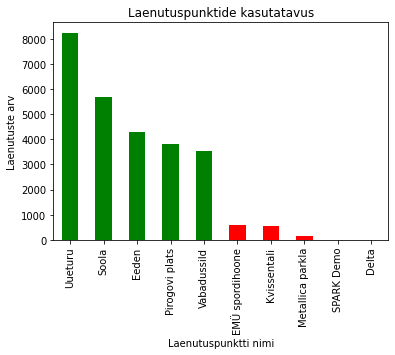

In [16]:
#5 kõige populaarsemat ja 5 vähem kasutatud laenutuspunkti sõidu alustamise järgi joonisele
laenutusjoonis_df=(rattaringlus_df["Start Station"].value_counts())
top5_df = laenutusjoonis_df.iloc[1:6]
last5_df = laenutusjoonis_df.iloc[-5:]
#paneme need kokku 1 tabeliks
laenutuspunktid = pd.concat([top5_df, last5_df])
#print(laenutuspunktid)
#print(type(laenutuspunktid))

import matplotlib.pyplot as plt
graafikuks = pd.Series(laenutuspunktid)
#print(graafikuks)

#värvime viie populaarsema laenutuspunkti tulbad roheliseks ja viie vähempopulaarsema laenutuspunkti tulbad punaseks
värvid = ["green", "green", "green", "green", "green", "red", "red", "red","red", "red"]

#loome tulpdiagrammi, mille X-teljel on laenutuspunktide nimi ja y-teljel laenutuste arv
graafikuks.plot.bar(xlabel="Laenutuspunktti nimi", ylabel="Laenutuste arv", title="Laenutuspunktide kasutatavus", color=värvid)
plt.show()

###Jalgrataste kuu keskmise kilometraaž.
Leiame jalgrataste kuu keskmise kilometraazi hoolduste planeerimiseks. Jalgrataste hooldusintervall on iga 1500km tagant, tuleb leida ka need jalgrattad, mis on juba esimese kuuga 1500km läbinud, et need korralisse hooldusesse tuua.

In [18]:
#leiame iga jalgratta kilometraaži
#loome uue dataframe'i
labisoit_df = pd.DataFrame(rattaringlus_df, columns=['Bike No', 'Length'])
#print(labisoit_df)

#grupeerime andmed ratta numbri järgi ning summerime iga ratta läbisõidu.
df2 = labisoit_df.groupby(['Bike No'])['Length'].sum().reset_index(name='Läbisõit')
#print(df2)

#Sorteerime tulemused läbisõid järgi
final_df2 = df2.sort_values(by=['Läbisõit'], ascending=False)
#prindime välja tulemused ja andmetüübi
print(final_df2)
print(type(final_df2))

     Bike No  Läbisõit
410     2495   1812.66
271     2343   1652.00
16      2060   1564.60
53      2101   1539.87
261     2332   1534.01
..       ...       ...
119     2173      0.00
428     2517      0.00
429     2518      0.00
198     2263      0.00
580     2741      0.00

[613 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [19]:
#Leiame rattad, mille läbisõit on üle 1500km
ule1500_df=final_df2.loc[final_df2["Läbisõit"]>1500]
print(display(ule1500_df))
print(type(ule1500_df))

,Bike No,Läbisõit
410,2495,1812.66
271,2343,1652.00
16,2060,1564.60
53,2101,1539.87
261,2332,1534.01
92,2144,1528.46
153,2210,1514.94
145,2202,1502.63


None
<class 'pandas.core.frame.DataFrame'>


Punasega on graafikul toodud rattad, mis on sõitnud üle 1500km ja tuleb kohe hooldusesse tuua. Rohelisega rattad pole veel 1500km piiri ületanud.


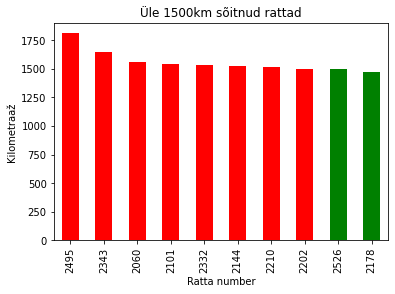

In [20]:
#Järgneb näide kuidas saada andmed graafikuks vajalikule kujule, kui ei oska hästi Pythonit
rattaID = np.array([2495, 2343, 2060, 2101, 2332, 2144, 2210, 2202, 2526, 2178])
labisoit = np.array([1812.66, 1652.00, 1564.60, 1539.87, 1534.01, 1528.46, 1514.94, 1502.63, 1497.15, 1473.42])
graafikukskoos = pd.Series(labisoit, index=rattaID)
#print(graafikukskoos)

print("Punasega on graafikul toodud rattad, mis on sõitnud üle 1500km ja tuleb kohe hooldusesse tuua. Rohelisega rattad pole veel 1500km piiri ületanud.")
värvid2 = ["red", "red", "red", "red", "red", "red", "red", "red","green", "green"]

#loome tulpdiagrammi, mille X-teljel on laenutuspunktide nimi ja y-teljel laenutuste arv
graafikukskoos.plot.bar(xlabel="Ratta number", ylabel="Kilometraaž", title="Üle 1500km sõitnud rattad", color=värvid2)
#plt.show()

In [21]:
#vaatame rataste kilometraaži tulba statistikuid
print(final_df2["Läbisõit"].describe(), "\n")

#Keskmine ratta läbisõit, tulemus ümardatud kahe komakohani
keskmineläbisõit = (round(final_df2["Läbisõit"].mean(), 2))
print("Kesmine rataste läbisõit on " + str(keskmineläbisõit) + " km.")

count     613.000000
mean      668.436378
std       393.938214
min         0.000000
25%       374.110000
50%       625.130000
75%       980.580000
max      1812.660000
Name: Läbisõit, dtype: float64 

Kesmine rataste läbisõit on 668.44 km.


### 5 kõige problemaatilisemat laenutuskohta
Leiame 5 kõige problemaatilisemat laenutuskoha, kus esines enim probleeme jalgrataste dokkist kättesaamisega, et hooldusmeeskond saaks nende laenutuspunktide kontrollerid välja vahetada.

,Start Station,End Station,Length
235,Undetermined,Aparaaditehas,0.0
334,Undetermined,ERM,0.0
340,Undetermined,ERM,0.0
350,Undetermined,Papli,0.0
407,Undetermined,Raatuse kool,0.0
...,...,...,...
169896,Undetermined,Tamme kool,0.0
169942,Undetermined,Annelinna keskus,0.0
169976,Undetermined,Karete,0.0
170006,Undetermined,Tamme kool,0.0


None
<class 'pandas.core.frame.DataFrame'>

Uueturu           1085
Lõunakeskus        964
Soola              879
Aleksandri         599
Pirogovi plats     542
Name: End Station, dtype: Int64


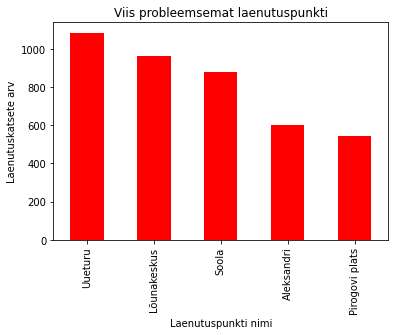

In [22]:
#defineerime tingimused, mille alusel ütleme, et esines probleem jalgrataste kättesaamisega
#laenutuspunkti nimi=Undetermined  ja tagastuspunkti olemas ning sõidu kilometraaž null.

#teeme uue andmefreimi
probleemne_df = pd.DataFrame(rattaringlus_df, columns=['Start Station', 'End Station', 'Length'])
#print(probleemne_df)
print()

#otsime üles laenutused, kui ratast ei saadud kätte
probleemnepunkt_df=probleemne_df.loc[probleemne_df["Start Station"]=="Undetermined"]
sõidukilometraaznull = probleemnepunkt_df.loc[probleemnepunkt_df["Length"]<0.01]
print(display(sõidukilometraaznull))
print(type(sõidukilometraaznull))

print()

# Leiame viis kõige probleemsemat laenutuspunkti
kõigeprobleemsemad_df=sõidukilometraaznull["End Station"].value_counts()
neg_df = kõigeprobleemsemad_df.head(5)
print(neg_df)


#värvime viie populaarsema laenutuspunkti tulbad roheliseks ja viie vähempopulaarsema laenutuspunkti tulbad punaseks
värvid3 = ["red", "red", "red", "red", "red"]

#loome tulpdiagrammi, mille X-teljel on laenutuspunktide nimi ja y-teljel probleemsete laenutuskatsete arv
neg_df.plot.bar(xlabel="Laenutuspunkti nimi", ylabel="Laenutuskatsete arv", title="Viis probleemsemat laenutuspunkti", color=värvid3)
plt.show()